<a href="https://colab.research.google.com/github/thanhyx4/Drone-Resupply/blob/main/GA_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [553]:
import copy
import math
import time
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [554]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [555]:
start_time = time.time()

with open('/content/drive/My Drive/Colab Notebooks/DataPrj_EC/100cus.dat', 'r') as f:
  file1 = []
  for line in f:
    file1.append(line)

# READ DATA

In [556]:
def readData(file1):
  num_customers = int(file1[0].split()[1])  - 1       #except depot
  num_trucks = 2
  num_drones = int(file1[2].split()[1])
  listX = []
  listY = []
  W = []
  for i in range(5,5+num_customers):
    line_i = file1[i].split()
    listX.append(line_i[0])
    listY.append(line_i[1])
    W.append(line_i[6])
  return listX, listY, W

X, Y, W = readData(file1)           #
X = np.array(X, dtype=int)
Y = np.array(Y, dtype =int)
W = np.array(W, dtype = int)

In [557]:
# Thư viện
import re
import itertools
import numpy as np

# Lấy các số từ chuỗi (Phải có khoảng cách giữa chữ và số)


def getNumber(str):
    # Mảng chứa các số kiểu chuỗi
    numberList = re.findall(r'\b\d+\b', str)
    # Chuổi đổi sang kiểu số
    return int(numberList[0])


def getAllPermutations(array):
    # Mảng chứa tất cả các hoán vị
    output = []
    # Là hoán vị
    subArr = []
    # danh sách các hoán vị
    permutations = itertools.permutations(array)
    count = 100
    # Lấy từng hoán vị
    for perm in permutations:
        subArr = list(perm)
        output.append(subArr)
        count -= 1
        if(count ==0):
         break
    # Trả về
    return output


# LAI GHÉP

In [558]:
import random


def standardized_gene(parent, drone):
    drone_pmx=[]
    parentTemp = []
    count = 0
    indexOfNegativeNum = []
    for i in parent:
        if i < 0:
            # Lưu lại vị trí các vách ngăn
            indexOfNegativeNum.append(count)
        else:
            # Tạo mảng mới toàn số dương
            parentTemp.append(i)
            drone_pmx.append(i)
        count += 1
    return parentTemp, drone_pmx, indexOfNegativeNum


def format_gene(child, drone, indexOfNegativeNum):
    for i in indexOfNegativeNum:
        child.insert(i, -1)
        drone.insert(i,0)
    return child, drone

# Phép lai ánh xạ từng phần (PMX - Partial Mappel Crossover)


def PMX_crossover(parent1, parent2, drone1, drone2):
    '''
    parent1 and parent2 are lists
    '''
    indexOfNegativeNum1 = []
    indexOfNegativeNum2 = []
    parent1_pmx, drone1_pmx, indexOfNegativeNum1 = standardized_gene(parent1, drone1)
    parent2_pmx, drone2_pmx, indexOfNegativeNum2 = standardized_gene(parent2, drone2)

    length = len(parent1_pmx)  # Lấy chiều dài gen

    # Creating parameters for random sublist
    firstCrossPoint = random.randint(0, length - 2)       #0 -> length-2
    secondCrossPoint = random.randint(firstCrossPoint + 1, length - 1)    #length-1 -> length-1

    # Lấy 2 đoạn của 2 gen
    parent1MiddleCross = parent1_pmx[firstCrossPoint:secondCrossPoint]          #length-2
    parent2MiddleCross = parent2_pmx[firstCrossPoint:secondCrossPoint]

    drone1MiddleCross = drone1[firstCrossPoint:secondCrossPoint]
    drone2MiddleCross = drone2[firstCrossPoint:secondCrossPoint]
    # Create 2 temporary sub genes

    #find good pairs
    relations = []
    middletmp1 = list( set(parent1MiddleCross) - set(parent2MiddleCross) )
    middletmp2 = list( set(parent2MiddleCross) - set(parent1MiddleCross) )
    for i in range(len(middletmp1)):
        relations.append([middletmp1[i], middletmp2[i]])
    del middletmp1, middletmp2
    # Đối sánh
    for pair in relations:
      idx1 = parent1_pmx.index(pair[1])
      idx2 = parent2_pmx.index(pair[0])
      parent1_pmx[idx1] = pair[0]
      parent2_pmx[idx2] = pair[1]
      drone1_pmx[idx1] = drone1_pmx[parent1_pmx.index(pair[0])]
      drone2_pmx[idx2] = drone2_pmx[parent2_pmx.index(pair[1])]

    child1 = (parent1_pmx[:firstCrossPoint] +
              parent2MiddleCross + parent1_pmx[secondCrossPoint:])
    child2 = (parent2_pmx[:firstCrossPoint] +
              parent1MiddleCross + parent2_pmx[secondCrossPoint:])
    childDrone1 = (drone1[:firstCrossPoint] +
                   drone2MiddleCross + drone1[secondCrossPoint:])                  
    childDrone2 = (drone2[:firstCrossPoint] +
                   drone1MiddleCross + drone2[secondCrossPoint:])


    child1, childDrone1 = format_gene(child1,childDrone1,  indexOfNegativeNum1)
    child2, childDrone2  = format_gene(child2, childDrone2, indexOfNegativeNum2)

    # Trả về 2 cá thể
    if( sum(list(child1)) != sum(list(child2)) | sum(list(parent1)) != sum(list(child1)) ):
      print(parent1)
      print(parent2)
      print(parent1MiddleCross)
      print(parent2MiddleCross)
      print(relations)
      print(child1)
      print(child2)
      return 0
    else:
      return child1, child2, childDrone1, childDrone2

# ĐỘT BIẾN ĐỔI CHỖ 2 ĐIỂM

In [559]:
import random
def MutationSwap2Point(GenTruck, GenDrone):
  length = len(GenTruck)
  first =random.randint(0, length-1)
  second = random.randint(0, length-1)
  while((first == second) | (GenTruck[first] == GenTruck[second])):
    first =random.randint(0, length-1)

  childTruck = copy.deepcopy(GenTruck)
  childTruck[first], childTruck[second] = childTruck[second], childTruck[first]
  childDrone = copy.deepcopy(GenDrone)
  childDrone[first], childDrone[second] =  childDrone[second], childDrone[first]
  return childTruck, childDrone


# ĐỘT BIẾN ĐỔI CHỖ 2 ĐOẠN

In [560]:
import random
import math
def MutationSwap2Line(parent):
  length= len(parent)
  line = math.floor(length/10)
  #print(line)
  firstMutation = random.randint(0, 2*line)
  secondMutation = random.randint(firstMutation + line, length -1 - line)
  #print(firstMutation, secondMutation)
  child = copy.deepcopy(parent)
  #print(child)
  i=0
  while(i<line):
    child[firstMutation + i], child[secondMutation + i] = child[secondMutation + i], child[firstMutation + i]
    i += 1
  return child

def main():
    print(MutationSwap2Line([6, 9, 7, -1, 4, 3, 8, -1, 2, 5, 10, 1]))


if __name__ == '__main__':
    main()

[6, 7, 9, -1, 4, 3, 8, -1, 2, 5, 10, 1]


# INIT SOLUTION

In [561]:
# import libraries
import numpy as np
import math
import random
# Hằng số
NUMBER_OF_TRUCKS = 3
NUMBER_OF_DRONES = 3
TRUCK_SPEED = 30  # km/h
DRONE_SPEED = TRUCK_SPEED * 1.5
DRONE_LIMIT_TIME = 15  # phút
N = 6  # Lấy dữ liệu từ dòng số 6
LIMITED_GENS = 100  # Số lượng gen giới hạn

# Lấy mảng chứa các dòng dữ liệu trong file
#lines = file.readFollowingLines(N)
lines = file1[5:]

# Khởi báo các biến
numberOfTrucks = NUMBER_OF_TRUCKS  # số lượng xe tải
numberOfCustomers = len(lines)                                                                          # số lượng khách hàng + 1
numberOfDrones = NUMBER_OF_DRONES  # số lượng drone
customerX = []  # Lưu trữ hoành độ của các khách hàng
customerY = []  # Lưu trữ tung độ của các khách hàng
releaseDate = []  # Lưu thời gian sản phẩm sẵn sàng của các khách hàng
vector = []  # vector nối các depot với các vị trí khách hàng
angles = np.zeros((numberOfCustomers, numberOfCustomers)
                  )  # chứa góc các vector với nhau
# Mảng chứa thời gian bay của drone đến các vị trí khách hàng
# Nếu vị trí khách hàng nằm ngoài khoảng bay được của drone -> gán -1
timeDepotToCusByDrone = []
# mảng chứa tổng thời gian từ depot đến vị trí khách hàng và release date
heuristicTime = [0]
# Trung bình (Thời gian từ depot đến vị trí các khách hàng + release date)
averageOfHeuristicTime = 0
# Mảng chứa vị trí các khách hàng đến thăm của từng xe tải
destination = []
# Mảng chứa điểm đến của các xe tải
truckDestinations = [[]]
# Phương sai
variance = 0
# Mảng chứa các thời gian di chuyển của truck giữa các điểm
timeOfDesToDes = np.zeros((numberOfCustomers, numberOfCustomers))

# Khởi tạo các biến
for line in lines:
    lineNum = line.split()
    customerX.append(int(lineNum[0]))  # customerX[0] : depot
    customerY.append(int(lineNum[1]))
    releaseDate.append(int(lineNum[-1]))
    # khởi tạo vector tạo bởi all data point (include depot point) and depot
    # vector by depot point and all data point (include depot)
    vector.append([customerX[-1] - customerX[0], customerY[-1] - customerY[0]])

# Khởi tạo mảng chứa các thời gian di chuyển của truck giữa các điểm
for i in range(0, numberOfCustomers):
    for j in range(i + 1, numberOfCustomers):
        # Tinh khoang cach theo mahattan
        distance = abs(customerX[i] - customerY[i]) + \
            abs(customerX[j] - customerY[j])
        # t = s / v
        time_truck = distance / TRUCK_SPEED
        timeOfDesToDes[i][j] = timeOfDesToDes[j][i] = time_truck * \
            60  # Truck_time all data point

# khởi tạo mảng chứa thời gian bay của drone
for arr in vector:
    # Tính khoảng cách theo eclip
    distance = math.sqrt(arr[0] * arr[0] + arr[1] * arr[1])
    # Tính thời gian
    time_drone = distance / DRONE_SPEED * 60  # đổi ra phút
    # Kiểm tra giới hạn bay
    if (time_drone <= DRONE_LIMIT_TIME):
        timeDepotToCusByDrone.append(time_drone)
    else:
        timeDepotToCusByDrone.append(-1)  # flying time: include depot to depot


# Khởi tạo mảng các góc giữa các vector


def getAngle(v1, v2):
    numerator = v1[0] * v2[0] + v1[1] * v2[1]
    denominator = math.sqrt(v1[0] * v1[0] + v1[1] * v1[1]) * \
        math.sqrt(v2[0] * v2[0] + v2[1] * v2[1])
    cos = round(numerator/denominator, 10)
    angle = math.degrees(math.acos(cos))
    return angle  # ?tinh cos nay khong the hien duoc goc tu` -> tinh

#0 <=  max_angle <= 180
# truong hop: max_angle < 180, max_angle = 180 ( 360, < 360)
# objective: tu 1 diem -> xac dinh thu tu cac diem theo 1 vong tron

    # vector[0] = 0 (vector by depot point & itself)
for i in range(1, numberOfCustomers):
    for j in range(i, numberOfCustomers):
        angles[i][j] = getAngle(vector[i], vector[j])
        # matrix angles: angle by customer i and customer j (numberOfCustomer x numberOfCustomer)
        angles[j][i] = angles[i][j]
        #vector[0], vector[j] = 0

# Khởi tạo mảng chứa thời gian ước lượng từ gốc depot đến vị trí các khách hàng
for i in range(1, numberOfCustomers):
    # append thời gian
    heuristicTime.append(timeOfDesToDes[0][i] + releaseDate[i])
    # tính tổng
    averageOfHeuristicTime += heuristicTime[-1]

# Khời tạo giá trị trung bình
averageOfHeuristicTime /= NUMBER_OF_TRUCKS
# Khởi tạo phương sai
variance = averageOfHeuristicTime / 5

# chuyển đổi list sang array
customerX = np.array(customerX)
customerY = np.array(customerY)
releaseDate = np.array(releaseDate)
vector = np.array(vector)

# Lấy 1 vị trí khách hàng ngẫu nhiên
customerLocation = random.randint(1, numberOfCustomers - 1)

# Lặp từ phần tử đầu đến kế cuối,
# Vì khi đến phần tử cuối là đã sắp xếp thành công


def getCustomerList(arr):
    # Khởi tạo vị trí khách hàng
    location = []
    for i in range(0, numberOfCustomers):
        location.append(i)
    # Hoán đổi vị trí
    for i in range(0, numberOfCustomers):
        for j in range(i + 1, numberOfCustomers):
            if (arr[i] > arr[j]):
                # Hoán đổi giá trị
                tmp = arr[i]
                arr[i] = arr[j]
                arr[j] = tmp
                # hoán đổi vị trí
                tmp = location[i]
                location[i] = location[j]
                location[j] = tmp
    return location


# Sắp xếp vị trí các khách hàng theo góc quay từ bé đến lớn
# angles[7]: list of angles is created by vector(depot, customer_7) and other vectors ???
locations = getCustomerList(angles[customerLocation])
# and then sort them ?
# issue: trường hợp tốt nhất các điểm customer ở xung quanh depot, sắp xếp theo angles giữa 1 điểm và các điểm còn lại thì thứ tự các điểm vẫn bị lộn xộn theo 2 phía của điểm được chọn ban đầu
# -> correct: xây dựng location: xuất phát từ 1 điểm bất kì, điểm tiếp theo  = góc nhỏ nhất giữa điểm đang xét và tất cả các điểm còn lại


# Cập nhật mảng đích đến
count = NUMBER_OF_TRUCKS - 1
lastIndex = 1
for i in range(1, numberOfCustomers):
    if (count > 0):
        sum = 0
        for j in range(lastIndex, i + 1):
            sum += heuristicTime[locations[j]]
        if (abs(sum - averageOfHeuristicTime) <= variance):
            for k in range(lastIndex, i + 1):
                destination.append(locations[k])
            lastIndex = i + 1
            destination.append(-1)
            count -= 1


for k in range(lastIndex, numberOfCustomers):
    destination.append(locations[k])

# Cập nhật mảng 2 chiều chứa các điểm đến của từng xe
for location in destination:
    if (location != -1):
        truckDestinations[-1].append(location)
    else:
        truckDestinations.append([])
del time_truck, time_drone, sum

# Algorithm
# Thiết lập mảng chứa các đoạn gen chưa hoàn chỉnh
subGensTable = []
for i in range(NUMBER_OF_TRUCKS):
    subGensTable.append(getAllPermutations(truckDestinations[i]))

# Thiết lập mảng chứa các gen hoàn chỉnh
# Bảng gen drone
gensDroneTable = []
for i in range(LIMITED_GENS):
    # Khởi tạo từng gen
    gensDroneTable.append([])
    for j in range(numberOfCustomers + NUMBER_OF_TRUCKS - 2):
        # Lấy ngẫu nhiên 1 số từ 0 đến 1
        randomNum = random.random()
        # Đẩy vào mảng cuối cùng của bảng genes
        gensDroneTable[-1].append(randomNum)
# Bảng gen Trucks
gensTable = []
for i in range(LIMITED_GENS):
    # Khởi tạo từng gen
    gensTable.append([])
    for subgen in subGensTable:
        # Lấy ngẫu nhiên 1 đoạn gen
        randomIndex = random.randint(0, len(subgen) - 1)
        # Đẩy vào đoạn gen chưa hoàn chỉnh
        gensTable[-1] += subgen[randomIndex] + [-1]
    # Loại bỏ -1 ở cuối mảng
    gensTable[-1].pop()


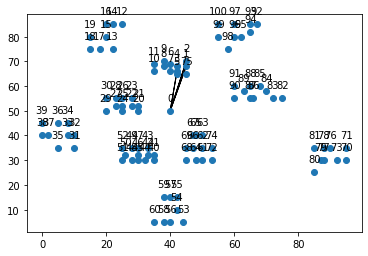

In [562]:
plt.plot(customerX, customerY, 'o')

for i in range(len(customerX)):
    label = i
    plt.annotate(label, # this is the text
                 (customerX[i],customerY[i]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.arrow(customerX[0], customerY[0], customerX[1] -customerX[0], customerY[1] - customerY[0])
plt.arrow(customerX[0], customerY[0], customerX[2] -customerX[0], customerY[2] - customerY[0])
plt.arrow(customerX[0], customerY[0], customerX[5] -customerX[0], customerY[5] - customerY[0])
plt.show()

# TSP-TW

In [563]:
def fitness(timeDepotToCusByDrone, timeOfDesToDesByTruck, destination, gen_drone):  #version chưa tính đến số lượng drone 
  #split gene trucks_routing to list truck_routing
  #modify gen_drone
  truckDestinations = [[] for i in range(NUMBER_OF_TRUCKS) ]
  gen_drone0 = [[] for i in range(NUMBER_OF_TRUCKS) ]
  tmp=0
  # print(destination)
  for i in range(len(destination)):
    if (destination[i] > 0):
        truckDestinations[tmp].append(destination[i])
        if (timeDepotToCusByDrone[destination[i]] != -1):
          gen_drone0[tmp].append( int( gen_drone[i] >= 0.5) )
        else:
          gen_drone0[tmp].append(0)
    else:
        tmp += 1
  del tmp
  # print(truckDestinations)
  # print(gen_drone0)
  #
  Tij =  timeOfDesToDesByTruck
  service_time = 0

  #Calculate Time_visit 
  Ti = [[] for i in range(NUMBER_OF_TRUCKS)]
  for truck_i in range(NUMBER_OF_TRUCKS):
    if len(truckDestinations[truck_i]) == 0:                            #truck k co job
      Ti[truck_i].append(0)
    else:
      if gen_drone0[truck_i][0] == 0:                                    #check first visit by truck
        i=1
        while ( i < len(truckDestinations[truck_i])) and (gen_drone0[truck_i][i] == 0):
          i = i + 1
        Ti[truck_i].append(np.max(releaseDate[truckDestinations[truck_i][:i]]) + Tij[0][truckDestinations[truck_i][0]] )
      else:
        Ti[truck_i].append(Tij[0][truckDestinations[truck_i][0]])       #khoi tao T0

      for i in range(len(truckDestinations[truck_i]) - 1):               
        if gen_drone0[truck_i][i] == 0:                              #có đường đi của drone: check vị trí đó trên mảng drone
          waitting_time = 0
        else:
          j=i+1
          while( j < len(truckDestinations[truck_i]) ) and (gen_drone0[truck_i][j] == 0)  :
            j = j+1
          waitting_time = max(0, np.max(releaseDate[truckDestinations[truck_i][i:j]] )  - Ti[truck_i][-1] - service_time + timeDepotToCusByDrone[truckDestinations[truck_i][i]] )
        Ti[truck_i].append(Ti[truck_i][-1] + service_time + waitting_time  + Tij[truckDestinations[truck_i][i]][truckDestinations[truck_i][i+1]] )
      #add time truck return to depot
      Ti[truck_i].append(Ti[truck_i][-1] + service_time + Tij[truckDestinations[truck_i][-1]][0])

#    #Time_visit[0][j]: thoi gian truck 0 đến khach hang thu j+1 trong list khach hang can tham
#    #khởi tạo Time_visit[0][0]:  thời gian truck 0 đến khách hàng thứ 1 trong list khách hàng mình cần đến 
#    #Time_visit[0][j] = Time_visit[0][j-1]  + waitting_time_tai_j + service_time + Truck_time[khach_hang_thu_j][khach hang_thu_j+1] 
          #gen_drone[0][j] = 1 : below
          #gen_drone[0][j] = 0 : waitting_time_tai_j = 0
#    #waitting_time_tai_j = max(0, max of releaseDate của những điểm tiếp theo truck cần phải đến thăm (giữa điểm khách hàng hiện tại và tiếp theo được resupply bởi drone) - Time_visit[0][j-1] - service_time + flying time )
#             #giới hạn drone ->waitting_time: + thời gian chờ drone khác bay về depot + thời gian sạc của drone 
  
  return 1/max(tv[-1] for tv in Ti)       #1/complete_time  (hour)
  #return Ti             


In [564]:
print(fitness(timeDepotToCusByDrone, timeOfDesToDes, gensTable[8], gensDroneTable[8]))

0.00016307893020221786


# CHỌN LỌC THEO ROULETTE

In [565]:
import random
def SelectionByRoulette(GensTruck, GensDrone):
  F = 0 #tong do thich nghi cua quan the
  q=0
  ps =[] #xac suat lua chon ca the thu i
  qs =[] #xac suat quy tich ca the thu i
  # print(r)
  selectGensDrone = []
  selectGensTruck = [] # mang chua cac genTruck duoc chon
                # ca the i duoc chon neu Qi-1 <= r <= Qi voi i > 1 hoac r <Q1 voi i = 1
  fits = [] # mang luu tru do thich nghi cua tung ca the
  #tinh do thich nghi cua tung ca the fits[i]
  for i in range(len(GensTruck)):
    f = fitness(timeDepotToCusByDrone, timeOfDesToDes, GensTruck[i], GensDrone[i])
    fits.append(f)
    F+=f
  #print(min(fits))
#  Lay ra gene có fitness tốt nhất
  index1 = fits.index(max(fits))
  selectGensTruck.append(GensTruck[index1])
  selectGensDrone.append(GensDrone[index1])
  GensTruck.pop(index1)
  GensDrone.pop(index1)
  #print("Gia tri tot nhat cua the he nay la",fits[index1])
  F -= fits[index1] 
  fits.pop(index1)
  #chon ca the tot thu 2 cho vao the he sau
  index2 = fits.index(max(fits))
  selectGensTruck.append(GensTruck[index2])
  selectGensDrone.append(GensDrone[index2])
  GensTruck.pop(index2)
  GensDrone.pop(index2)
  F-=fits[index2]
  fits.pop(index2)
  # for fit in fits:
  #   F += fit
  # print("Độ dài ", len(fits))
  #tinh do xac suat lua chon ca the thu i ps[i]
  for i in range(len(fits)):
    tg =round(fits[i]/F, 4)
    ps.append(tg)
  #tinh xac suat quy tich ca the thu i qs[i]
  for p in ps:
    q+= p
    qs.append(q)
      # print("=======")
  #chon loc ca the selections
  while((len(selectGensTruck) <100)):
    r = random.random() #lay ngau nhien so thuc r trong doan [0;1]
    for i in range(len(qs)):
      if(qs[0] > r):
        selectGensTruck.append(GensTruck[i])
        selectGensDrone.append(GensDrone[i])
        break;
      if((qs[i-1] < r) & (qs[i] > r)):
        selectGensTruck.append(GensTruck[i])
        selectGensDrone.append(GensDrone[i])
        break;
  fits.clear()
  ps.clear()
  qs.clear()
  F=0
  q=0
#  print(len(selectGensDrone))
  return selectGensTruck, selectGensDrone

# GA

In [566]:
def GA(GensTruck, GensDrone):
  newGensTruck =[]
  newGensDrone =[]
  for i in range(len(GensTruck)):
      # Lấy ngẫu nhiên 2 gen trong bảng gen
      nextIndex = random.randint(0, len(GensTruck) - 1)
      while (nextIndex == i):
          nextIndex = random.randint(0, len(GensTruck) - 1)
      # Lai ghép tạo gen mới
      newGens = PMX_crossover(
          GensTruck[i], GensTruck[nextIndex], GensDrone[i], GensDrone[nextIndex])
      if newGens == 0:
        return 0,0
#check wrong gen
      # count = 0
      # for i in newGens[0]:
      #     if (i == -1 ):
      #         count += 1
      # if (count ==(NUMBER_OF_TRUCKS -1 )):
      #     newGensTruck.append(newGens[0])
      #     newGensDrone.append(newGens[2])
      # # else: 
      # #   print(newGens[0])
      # count = 0
      # for i in newGens[1]:
      #     if (i == -1):
      #         count += 1
      # if (count ==(NUMBER_OF_TRUCKS -1 )):
      #   newGensTruck.append(newGens[1])
      #   newGensDrone.append(newGens[3])
      #Đột biến tạo gen mới
      rate_mutation = random.random()
      if (rate_mutation <= 5/100):
        newGens_mutation1 =  MutationSwap2Point(newGens[0], newGens[2])
        newGens_mutation2 =  MutationSwap2Point(newGens[1], newGens[3])
        newGensTruck.append(newGens_mutation1[0])
        newGensDrone.append(newGens_mutation1[1])
        newGensTruck.append(newGens_mutation2[0])
        newGensDrone.append(newGens_mutation2[1])
      else:
        newGensTruck.append(newGens[0])
        newGensDrone.append(newGens[2])
        newGensTruck.append(newGens[1])
        newGensDrone.append(newGens[3])
        
  gensTruck =[]
  gensDrone =[]
  gensTruck= GensTruck + newGensTruck
  gensDrone = GensDrone + newGensDrone
  # print(len(newGensTruck))
  # print(len(newGensDrone))
  return gensTruck, gensDrone

# HIỂN THỊ KẾT QUẢ QUA MỖI THẾ HỆ

In [567]:
import numpy as np
import matplotlib.pyplot as plt


def ResultAfterEachGeneration(NumberOfGenerations):
  j = 1
  fit =[]
  result =[]
  genTruck_best = []
  genDrone_best = []
  gensTruck, gensDrone = gensTable, gensDroneTable
  while(j <= NumberOfGenerations): 
    newGensTruck, newGensDrone = GA(gensTruck, gensDrone)
    if newGensTruck == 0:
      return 0
    for k in range(len(newGensTruck)):
      f = fitness(timeDepotToCusByDrone, timeOfDesToDes, newGensTruck[k], newGensDrone[k])
      fit.append(f)
    index1 = fit.index(max(fit))
    result.append(1/fit[index1])

    fit.clear()
    gensTruck, gensDrone = SelectionByRoulette(newGensTruck, newGensDrone)
    j+=1
  return result
  


# Result

--- Time Excution --- 91.20848321914673


Text(0.5, 1.0, 'Completion Time each Generations')

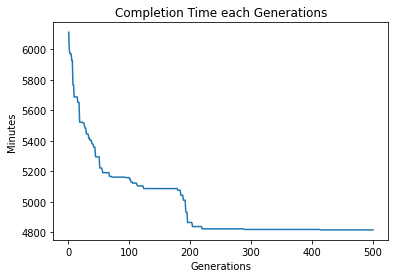

In [568]:
NumberOfGenerations = 500
results = ResultAfterEachGeneration(NumberOfGenerations)
print("--- Time Excution ---", (time.time() - start_time))
plt.plot(list(range(1,NumberOfGenerations+1 )),results)
plt.ylabel("Minutes")
plt.xlabel("Generations")
plt.title("Completion Time each Generations")

In [569]:
#ve duong di cac truck, drone
#gen truck split, gen drone